1. Imports and Data Loading

In [1]:
import os
import re
import string
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc, classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, GRU, Dense, Dropout, Lambda, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint



from transformers import AutoTokenizer, TFAutoModel
from sentence_transformers import SentenceTransformer
from wordcloud import WordCloud
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
train = pd.read_csv("/content/train.csv", encoding="latin1", on_bad_lines='skip')
train.head()


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [3]:
print("Loaded rows:", len(train))


Loaded rows: 404347


2. EDA

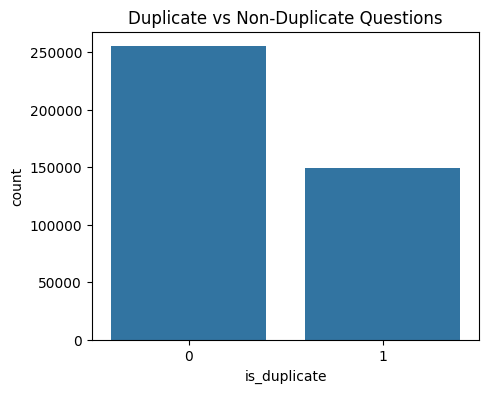

In [4]:
plt.figure(figsize=(5,4))
sns.countplot(x=train['is_duplicate'])
plt.title("Duplicate vs Non-Duplicate Questions")
plt.show()


In [5]:
train.isnull().sum()


,0
id,0
qid1,0
qid2,0
question1,1
question2,2
is_duplicate,0


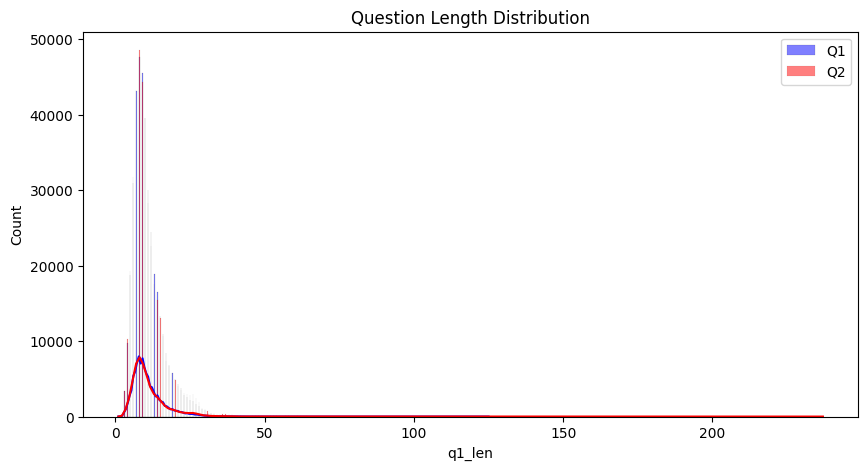

In [6]:
train['q1_len'] = train['question1'].astype(str).apply(lambda x: len(x.split()))
train['q2_len'] = train['question2'].astype(str).apply(lambda x: len(x.split()))

plt.figure(figsize=(10,5))
sns.histplot(train['q1_len'], kde=True, color='blue', label="Q1")
sns.histplot(train['q2_len'], kde=True, color='red', label="Q2")
plt.legend()
plt.title("Question Length Distribution")
plt.show()


(np.float64(-0.5), np.float64(599.5), np.float64(399.5), np.float64(-0.5))

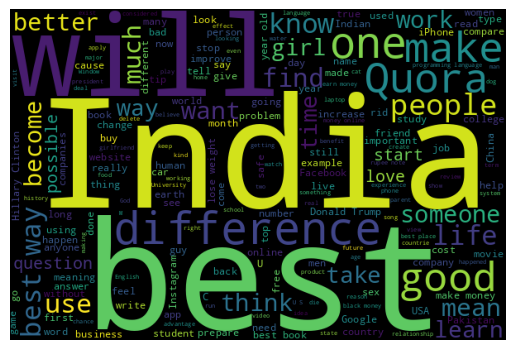

In [7]:
text = " ".join(str(q) for q in train['question1'])
wc = WordCloud(width=600, height=400).generate(text)
plt.imshow(wc); plt.axis("off")

3. Text Pre Processing

In [8]:
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-z0-9 ]", " ", text)
    text = " ".join(w for w in text.split() if w not in stop_words)
    return text


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
train['q1_clean'] = train['question1'].astype(str).apply(clean_text)
train['q2_clean'] = train['question2'].astype(str).apply(clean_text)


In [10]:
train_df, temp_df = train_test_split(
    train,
    test_size=0.2,
    random_state=42,
    stratify=train['is_duplicate']
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=42,
    stratify=temp_df['is_duplicate']
)

len(train_df), len(val_df), len(test_df)


(323477, 40435, 40435)

4. TF-IDF, Logistic Regression & SVM

* TF-IDF

In [11]:
tfidf = TfidfVectorizer(max_features=50000, ngram_range=(1,2))

all_texts = pd.concat([train_df['q1_clean'], train_df['q2_clean']])
tfidf.fit(all_texts)

TfidfVectorizer(max_features=50000, ngram_range=(1, 2))

In [12]:
def tfidf_pair_features(df):
    q1_tf = tfidf.transform(df['q1_clean'])
    q2_tf = tfidf.transform(df['q2_clean'])

    # SAFE: all sparse
    abs_diff = abs(q1_tf - q2_tf)
    mult = q1_tf.multiply(q2_tf)

    X = hstack([abs_diff, mult])
    return X


X_train_baseline = tfidf_pair_features(train_df)
y_train = train_df['is_duplicate'].values
X_val_baseline = tfidf_pair_features(val_df)
y_val = val_df['is_duplicate'].values

* Logistic Regression with Random Search

In [16]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(
    solver='liblinear',
    max_iter=2000,
    random_state=42
)

param_dist = {
    "C": [0.01, 0.1, 1, 10],
    "penalty": ["l2", "l1"]
}

rsearch = RandomizedSearchCV(
    lr,
    param_distributions=param_dist,
    n_iter=4,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1
)

rsearch.fit(X_train_baseline, y_train)

print("Best LR params:", rsearch.best_params_, "best f1:", rsearch.best_score_)
best_lr = rsearch.best_estimator_

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best LR params: {'penalty': 'l2', 'C': 10} best f1: 0.7376822524166693


In [17]:
y_pred_lr = best_lr.predict(X_val_baseline)
print("LR Val metrics:")
print(classification_report(y_val, y_pred_lr))
print("Confusion matrix:\n", confusion_matrix(y_val, y_pred_lr))

LR Val metrics:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86     25504
           1       0.76      0.74      0.75     14931

    accuracy                           0.82     40435
   macro avg       0.81      0.80      0.80     40435
weighted avg       0.82      0.82      0.82     40435

Confusion matrix:
 [[22068  3436]
 [ 3946 10985]]


5. Fully Connected ANN

In [20]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_WORDS = 60000
MAX_LEN = 30
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(pd.concat([train_df['q1_clean'], train_df['q2_clean']]))

In [21]:
def seqs(df):
    s1 = tokenizer.texts_to_sequences(df['q1_clean'])
    s2 = tokenizer.texts_to_sequences(df['q2_clean'])
    return pad_sequences(s1, maxlen=MAX_LEN), pad_sequences(s2, maxlen=MAX_LEN)

X1_train, X2_train = seqs(train_df)
X1_val, X2_val = seqs(val_df)
X1_test, X2_test = seqs(test_df)
y_train = train_df['is_duplicate'].values
y_val = val_df['is_duplicate'].values
y_test = test_df['is_duplicate'].values

In [28]:
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import Concatenate, Lambda
def build_ann_model(hp=None):
    vocab_size = MAX_WORDS
    emb_dim = 128 if hp is None else hp.Choice('emb_dim', [64, 128, 200])
    input1 = Input(shape=(MAX_LEN,))
    input2 = Input(shape=(MAX_LEN,))
    emb = Embedding(vocab_size, emb_dim, input_length=MAX_LEN)

    x1 = GlobalAveragePooling1D()(emb(input1))
    x2 = GlobalAveragePooling1D()(emb(input2))
    abs_diff = Lambda(lambda x: tf.abs(x[0] - x[1]))([x1, x2])
    x = Concatenate()([x1, x2, abs_diff])

    hidden_units = 128 if hp is None else hp.Choice('hidden_units', [64,128,256])
    x = Dense(hidden_units, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(hidden_units//2, activation='relu')(x)
    out = Dense(1, activation='sigmoid')(x)
    model = Model([input1, input2], out)
    lr = 1e-3 if hp is None else hp.Choice('lr', [1e-3, 1e-4, 5e-4])
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


In [29]:
ann = build_ann_model()
es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
ann.fit([X1_train, X2_train], y_train, validation_data=([X1_val, X2_val], y_val), epochs=5, batch_size=256, callbacks=[es])


y_pred_ann = (ann.predict([X1_val, X2_val]) > 0.5).astype(int)
print("ANN val report:")
print(classification_report(y_val, y_pred_ann))

Epoch 1/5
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.7236 - loss: 0.5276 - val_accuracy: 0.8016 - val_loss: 0.4185
Epoch 2/5
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.8607 - loss: 0.3112 - val_accuracy: 0.8261 - val_loss: 0.3781
Epoch 3/5
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.9047 - loss: 0.2221 - val_accuracy: 0.8325 - val_loss: 0.4286
Epoch 4/5
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9269 - loss: 0.1725 - val_accuracy: 0.8327 - val_loss: 0.4922
Epoch 5/5
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9386 - loss: 0.1452 - val_accuracy: 0.8249 - val_loss: 0.5193
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
ANN val report:
              precision    recall  f1-score   support

           0       0.89      0.82      0.86     25504
           1       0.73      0.83      0.78     14931

    accuracy                           0.83     40435
   macro avg       0.81      0.83      0.82     40435
weighted avg       0.83

In [30]:
y_pred_ann = (ann.predict([X1_val, X2_val]) > 0.5).astype(int)
print("ANN val report:")
print(classification_report(y_val, y_pred_ann))

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
ANN val report:
              precision    recall  f1-score   support

           0       0.89      0.82      0.86     25504
           1       0.73      0.83      0.78     14931

    accuracy                           0.83     40435
   macro avg       0.81      0.83      0.82     40435
weighted avg       0.83      0.83      0.83     40435



6. Siamese LSTM

In [33]:
def build_siamese(recurrent='lstm', hp=None):
    vocab_size = MAX_WORDS
    emb_dim = 128 if hp is None else hp.Choice('emb_dim', [64, 128])
    units = 128 if hp is None else hp.Choice('units', [64, 128, 256])
    drop = 0.3 if hp is None else hp.Choice('drop', [0.2, 0.3, 0.4])
    input_a = Input(shape=(MAX_LEN,))
    input_b = Input(shape=(MAX_LEN,))
    emb = Embedding(vocab_size, emb_dim, input_length=MAX_LEN)
    if recurrent == 'lstm':
        encoder = LSTM(units, dropout=drop, recurrent_dropout=0.0)
    else:
        encoder = GRU(units, dropout=drop, recurrent_dropout=0.0)
    encoded_a = encoder(emb(input_a))
    encoded_b = encoder(emb(input_b))

    diff = Lambda(lambda x: K.abs(x[0] - x[1]))([encoded_a, encoded_b])
    mult = Lambda(lambda x: x[0] * x[1])([encoded_a, encoded_b])
    x = Concatenate(axis=1)([diff, mult])
    x = Dense(128, activation='relu')(x)
    x = Dropout(drop)(x)
    out = Dense(1, activation='sigmoid')(x)
    model = Model([input_a, input_b], out)
    lr = 1e-3 if hp is None else hp.Choice('lr', [1e-3, 1e-4])
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [34]:
siam_lstm = build_siamese(recurrent='lstm')
siam_lstm.fit([X1_train, X2_train], y_train, validation_data=([X1_val, X2_val], y_val),
              epochs=5, batch_size=128, callbacks=[es])

Epoch 1/5
2528/2528 ━━━━━━━━━━━━━━━━━━━━ 52s 16ms/step - accuracy: 0.7286 - loss: 0.5264 - val_accuracy: 0.7991 - val_loss: 0.4327
Epoch 2/5
2528/2528 ━━━━━━━━━━━━━━━━━━━━ 79s 18ms/step - accuracy: 0.8375 - loss: 0.3613 - val_accuracy: 0.8115 - val_loss: 0.4132
Epoch 3/5
2528/2528 ━━━━━━━━━━━━━━━━━━━━ 49s 20ms/step - accuracy: 0.8726 - loss: 0.2902 - val_accuracy: 0.8216 - val_loss: 0.4021
Epoch 4/5
2528/2528 ━━━━━━━━━━━━━━━━━━━━ 54s 21ms/step - accuracy: 0.8944 - loss: 0.2434 - val_accuracy: 0.8148 - val_loss: 0.4206
Epoch 5/5
2528/2528 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - accuracy: 0.9089 - loss: 0.2134 - val_accuracy: 0.8181 - val_loss: 0.4448


In [35]:
y_pred_siam = (siam_lstm.predict([X1_val, X2_val]) > 0.5).astype(int)
print("Siamese LSTM val report:")
print(classification_report(y_val, y_pred_siam))

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
Siamese LSTM val report:
              precision    recall  f1-score   support

           0       0.90      0.80      0.85     25504
           1       0.72      0.85      0.78     14931

    accuracy                           0.82     40435
   macro avg       0.81      0.83      0.81     40435
weighted avg       0.83      0.82      0.82     40435



7. BERT Transfer Learning

In [45]:
print("Preparing Sentence-BERT embeddings (this may download a model if not present)...")
sbert_model = SentenceTransformer("all-MiniLM-L6-v2")


Preparing Sentence-BERT embeddings (this may download a model if not present)...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [46]:
def sb_encode(df, batch_size=256):
    q1_emb = sbert_model.encode(
        df['q1_clean'].tolist(),
        batch_size=batch_size,
        convert_to_numpy=True,
        show_progress_bar=True
    )

    q2_emb = sbert_model.encode(
        df['q2_clean'].tolist(),
        batch_size=batch_size,
        convert_to_numpy=True,
        show_progress_bar=True
    )

    return np.hstack([np.abs(q1_emb - q2_emb), q1_emb * q2_emb, q1_emb, q2_emb])



X_train_sbert = sb_encode(train_df)
X_val_sbert = sb_encode(val_df)
X_test_sbert = sb_encode(test_df)

Batches:   0%|          | 0/1264 [00:00<?, ?it/s]

Batches:   0%|          | 0/1264 [00:00<?, ?it/s]

Batches:   0%|          | 0/158 [00:00<?, ?it/s]

Batches:   0%|          | 0/158 [00:00<?, ?it/s]

Batches:   0%|          | 0/158 [00:00<?, ?it/s]

Batches:   0%|          | 0/158 [00:00<?, ?it/s]

In [52]:
from sklearn.decomposition import PCA

print("Running PCA reduction from 1536 → 256 dimensions...")
pca = PCA(n_components=256, random_state=42)

X_train_pca = pca.fit_transform(X_train_sbert)
X_val_pca = pca.transform(X_val_sbert)
X_test_pca = pca.transform(X_test_sbert)

print("Shapes after PCA reduction:")
print("X_train_pca:", X_train_pca.shape)
print("X_val_pca:", X_val_pca.shape)
print("X_test_pca:", X_test_pca.shape)

Running PCA reduction from 1536 → 256 dimensions...
Shapes after PCA reduction:
X_train_pca: (323477, 256)
X_val_pca: (40435, 256)
X_test_pca: (40435, 256)


In [53]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score

print("Training MLPClassifier on PCA-reduced SBERT features...")

mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    max_iter=30,
    random_state=42
)

mlp.fit(X_train_pca, y_train)

y_pred_mlp = mlp.predict(X_val_pca)

print("\nSBERT + PCA + MLP Validation Performance:")
print(classification_report(y_val, y_pred_mlp))


Training MLPClassifier on PCA-reduced SBERT features...


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(



SBERT + PCA + MLP Validation Performance:
              precision    recall  f1-score   support

           0       0.87      0.85      0.86     25504
           1       0.76      0.78      0.77     14931

    accuracy                           0.83     40435
   macro avg       0.81      0.82      0.82     40435
weighted avg       0.83      0.83      0.83     40435



In [55]:
y_test_siam = (siam_lstm.predict([X1_test, X2_test]) > 0.5).astype(int)
print("Siamese LSTM test report:")
print(classification_report(y_test, y_test_siam))

y_test_mlp = mlp.predict(X_test_pca)
print("SBERT+MLP test report:")
print(classification_report(y_test, y_test_mlp))

1264/1264 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
Siamese LSTM test report:
              precision    recall  f1-score   support

           0       0.91      0.80      0.85     25505
           1       0.72      0.86      0.78     14930

    accuracy                           0.82     40435
   macro avg       0.81      0.83      0.82     40435
weighted avg       0.84      0.82      0.82     40435

SBERT+MLP test report:
              precision    recall  f1-score   support

           0       0.87      0.85      0.86     25505
           1       0.76      0.78      0.77     14930

    accuracy                           0.83     40435
   macro avg       0.82      0.82      0.82     40435
weighted avg       0.83      0.83      0.83     40435



AUC (SBERT+MLP): 0.9084268532508697


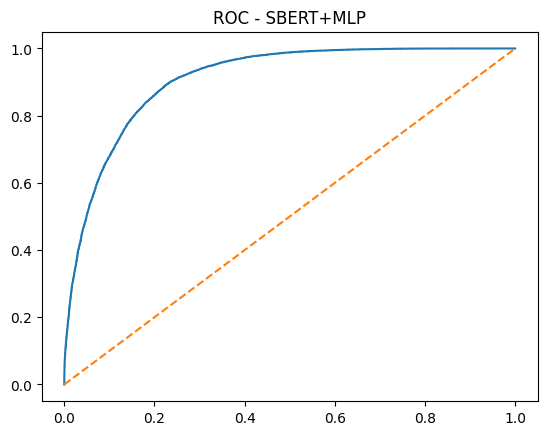

In [57]:
probs = mlp.predict_proba(X_test_pca)[:,1]
fpr, tpr, _ = roc_curve(y_test, probs)
print("AUC (SBERT+MLP):", auc(fpr, tpr))
plt.plot(fpr, tpr); plt.plot([0,1],[0,1],'--'); plt.title("ROC - SBERT+MLP"); plt.show()

8. Models Summary

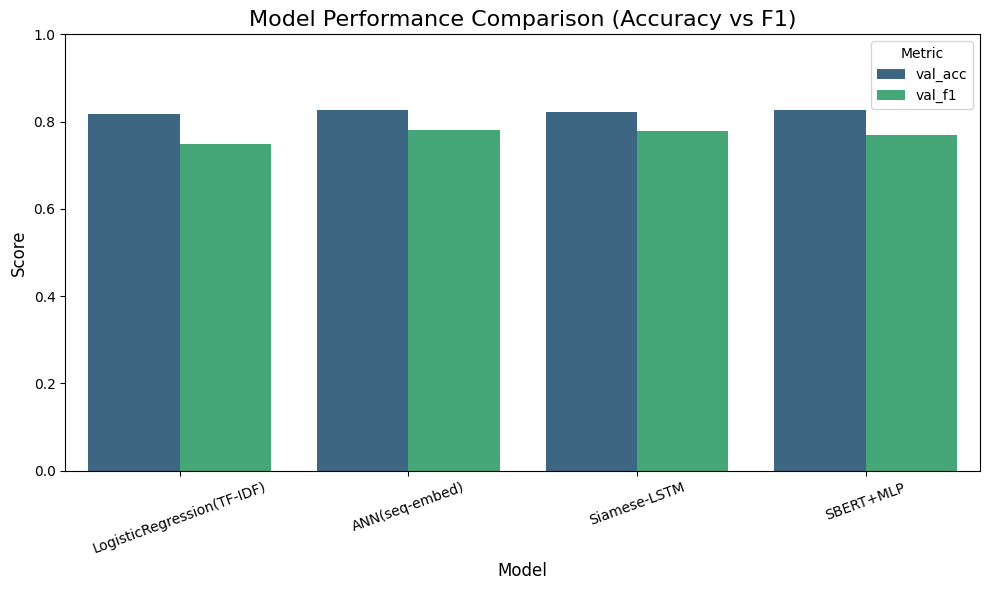

In [58]:
models_summary = [
    ("LogisticRegression(TF-IDF)", accuracy_score(y_val, y_pred_lr), f1_score(y_val, y_pred_lr)),
    ("ANN(seq-embed)", accuracy_score(y_val, y_pred_ann), f1_score(y_val, y_pred_ann)),
    ("Siamese-LSTM", accuracy_score(y_val, y_pred_siam), f1_score(y_val, y_pred_siam)),
    ("SBERT+MLP", accuracy_score(y_val, y_pred_mlp), f1_score(y_val, y_pred_mlp)),
]

df_results = pd.DataFrame(models_summary, columns=['model', 'val_acc', 'val_f1'])



plt.figure(figsize=(10,6))
df_results_melted = df_results.melt(id_vars='model', value_vars=['val_acc','val_f1'], var_name='metric', value_name='score')

sns.barplot(
    data=df_results_melted,
    x='model',
    y='score',
    hue='metric',
    palette='viridis'
)

plt.title("Model Performance Comparison (Accuracy vs F1)", fontsize=16)
plt.xlabel("Model", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.ylim(0, 1.0)
plt.xticks(rotation=20)
plt.legend(title="Metric")
plt.tight_layout()
plt.show()
